Found 7098 images belonging to 5 classes.
Found 1774 images belonging to 5 classes.
Found 1795 images belonging to 5 classes.
Number of Classes: 5
Train images: 7098
Val images: 1774
Test images: 1795


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

D:\plant-disease-project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
222/222 ━━━━━━━━━━━━━━━━━━━━ 155s 683ms/step - accuracy: 0.6352 - loss: 0.9813 - val_accuracy: 0.8360 - val_loss: 0.5096
Epoch 2/2
222/222 ━━━━━━━━━━━━━━━━━━━━ 149s 673ms/step - accuracy: 0.8195 - loss: 0.5149 - val_accuracy: 0.8918 - val_loss: 0.3460


✅ Model saved at ../models/best_model.h5


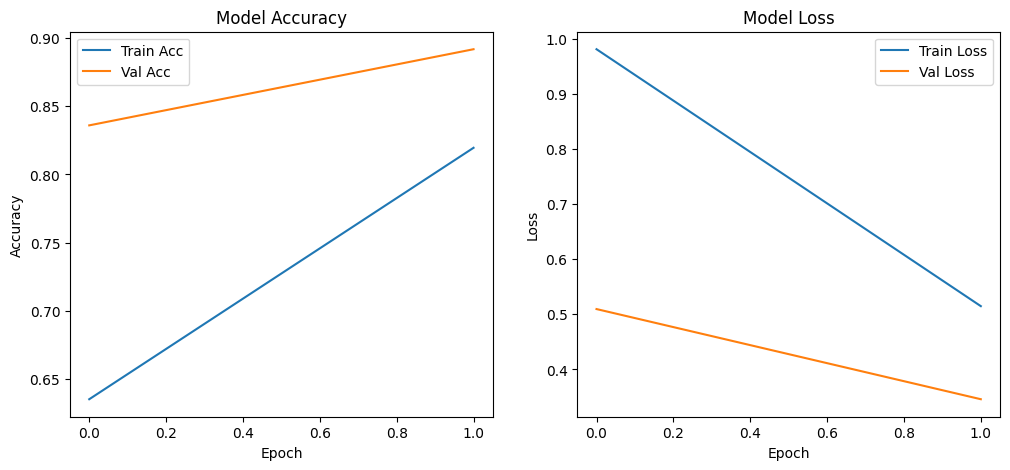

57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.8802 - loss: 0.3714
🧪 Test Accuracy: 0.88


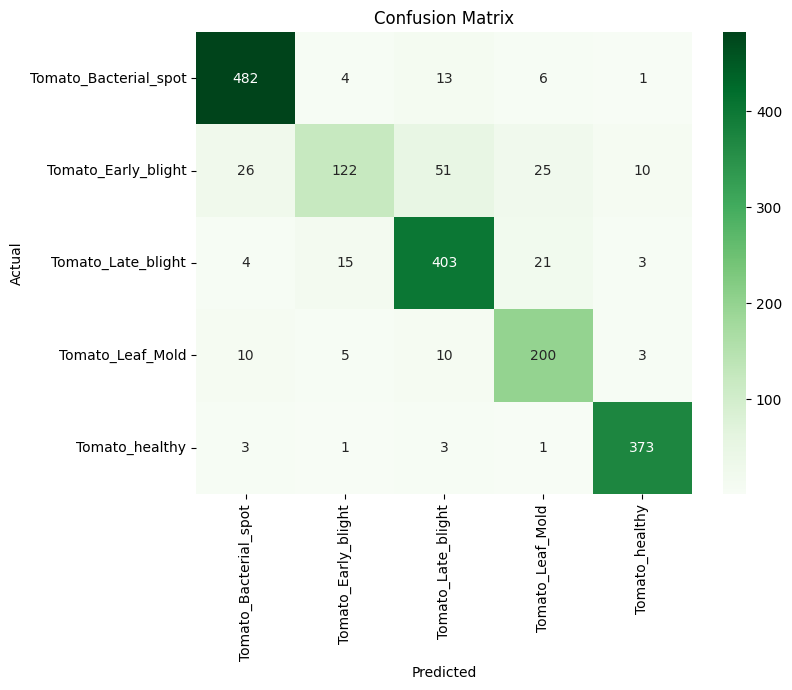

                       precision    recall  f1-score   support

Tomato_Bacterial_spot       0.92      0.95      0.94       506
  Tomato_Early_blight       0.83      0.52      0.64       234
   Tomato_Late_blight       0.84      0.90      0.87       446
     Tomato_Leaf_Mold       0.79      0.88      0.83       228
       Tomato_healthy       0.96      0.98      0.97       381

             accuracy                           0.88      1795
            macro avg       0.87      0.85      0.85      1795
         weighted avg       0.88      0.88      0.87      1795



In [1]:
# --- 1. Imports ---
%matplotlib inline
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 2. Paths ---
train_dir = "../data/processed/train"
val_dir = "../data/processed/val"
test_dir = "../data/processed/test"

# --- 3. Data Generators ---
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical',
    shuffle=False
)

num_classes = len(train_data.class_indices)
print("Number of Classes:", num_classes)
print("Train images:", train_data.samples)
print("Val images:", val_data.samples)
print("Test images:", test_data.samples)

# --- 4. Build Model ---
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=img_size + (3,))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()  # Display model architecture

# --- 5. Train Model ---
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,       # Change to 2 for quick test
    verbose=1        # Show progress in notebook
)

# --- 6. Save Model ---
os.makedirs("../models", exist_ok=True)
model.save("../models/best_model.h5")
print("✅ Model saved at ../models/best_model.h5")

# --- 7. Plot Accuracy and Loss ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# --- 8. Evaluate on Test Data ---
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"🧪 Test Accuracy: {test_acc:.2f}")

# --- 9. Confusion Matrix ---
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data, verbose=0), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=list(train_data.class_indices.keys()),
    yticklabels=list(train_data.class_indices.keys())
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 10. Classification Report ---
print(classification_report(y_true, y_pred, target_names=list(train_data.class_indices.keys())))
